### HW1 Nan Zhao

In [1]:
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import datetime 
import numpy as np
from numpy import polyfit
from math import sqrt
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error 
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.arima_model import ARIMAResults

## Problem 1
#### Perform a complete Box-Jenkins analysis to arrive at what you believe to be the optimum ARIMA(p,d,q) model

### a. Plot the series.

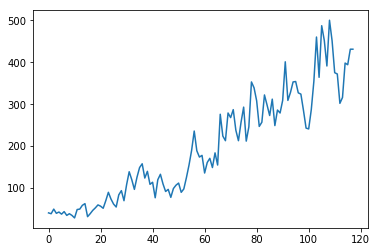

Number of points = 118


In [2]:
# Step 1: Plot data and determine seasonality and stationarity

series = pd.read_csv('robberies.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
X = series.values
y = X.astype('float64')

pyplot.plot(X) 
pyplot.show()
print('Number of points =', len(series))

### b. Perform a Dickey-Fuller test on the series. Is the series stationary?

In [3]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.001102
p-value: 0.994278
Critical Values:
	5%: -2.889
	10%: -2.582
	1%: -3.494


p-value > 0.05  
This time series is non-stationary.

### c. Plot the ACF & PACF and observe the trends.

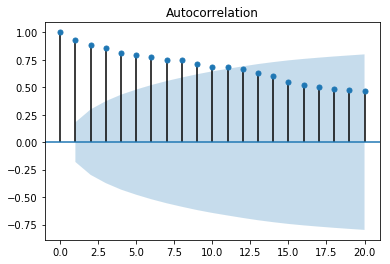

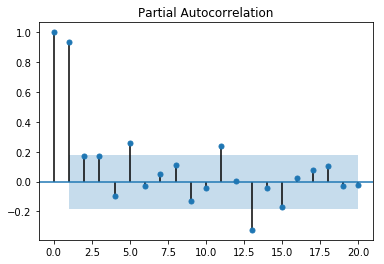

In [4]:
# ACF plot of time series
plot_acf(series, lags=20)
pyplot.show()

# PACF plot of time series
plot_pacf(series, lags=20)
pyplot.show()

ACF shows that this time series is not stationary

### d. Perform differencing on the series.

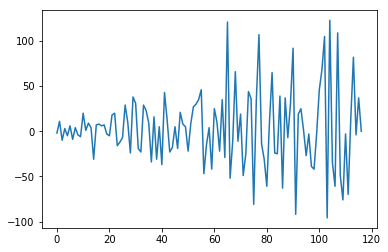

In [5]:
diff = list()
Diff=1
for i in range(Diff, len(X)):
    value = y[i] - y[i - Diff]
    diff.append(value) 
pyplot.plot(diff) 
pyplot.show()

### e. Is the differenced series stationary?

In [6]:
# Dickey-Fuller test 
result = adfuller(diff)
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.428564
p-value: 0.000000
Critical Values:
	5%: -2.889
	10%: -2.582
	1%: -3.494


p-value < 0.05  
The differencd series is stationary.

### f. Plot the ACF & PACF of the differenced data and select the p & q orders.

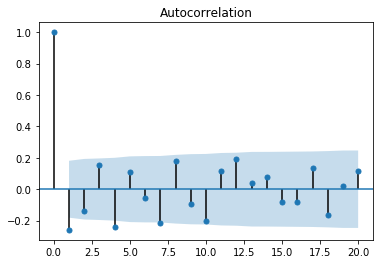

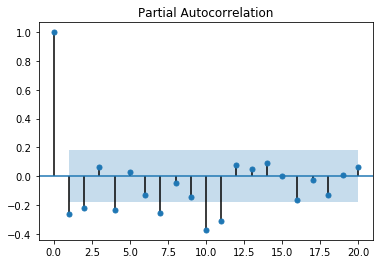

In [7]:
# ACF plot of time series
plot_acf(diff, lags=20)
pyplot.show()

# PACF plot of time series
plot_pacf(diff, lags=20)
pyplot.show()

In [8]:
# ACF   MA(1)  q=1 
# PACF  AR(2)  p=2 

### g. Run an ARIMA analysis with the original series and the (p,d,q) you've deduced from above. 

In [9]:
model = ARIMA(y, order=(2,1,1)) 
model_fit = model.fit(disp=0)
# summary of fit model 
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  117
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -592.107
Method:                       css-mle   S.D. of innovations             38.118
Date:                Fri, 22 Apr 2022   AIC                           1194.213
Time:                        23:10:58   BIC                           1208.024
Sample:                             1   HQIC                          1199.820
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2980      2.539      1.299      0.197      -1.679       8.275
ar.L1.D.y     -0.8811      0.168     -5.235      0.000      -1.211      -0.551
ar.L2.D.y     -0.3641      0.086     -4.243      0.0

### h. Plot the residuals.

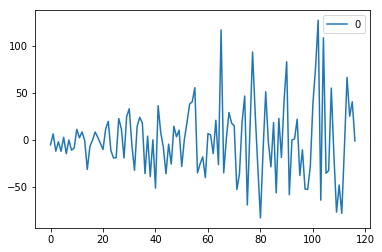

In [10]:
#line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

### i. Plot the residual distribution (kind='kde').

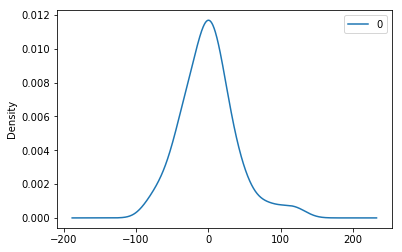

In [11]:
#density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

### j. Print the residuals summary.

In [12]:
#summary stats of residuals
print(residuals.describe())

                0
count  117.000000
mean     0.002909
std     38.282841
min    -83.077287
25%    -25.757267
50%     -0.239539
75%     18.435384
max    127.310477


### k. Plot the ACF & PACF and observe for residual correlations.

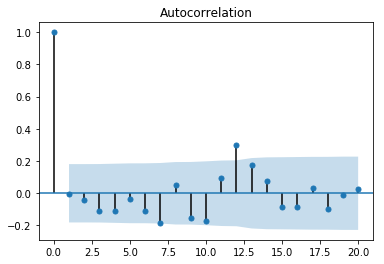

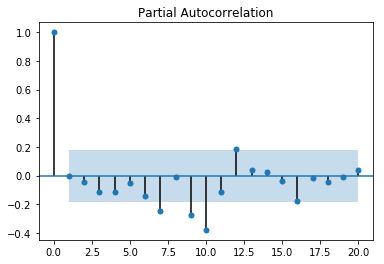

In [13]:
plot_acf(residuals, lags=20)
pyplot.show()
plot_pacf(residuals, lags=20)
pyplot.show()

We would not expect there to be any correlation between the residuals. This would be shown by autocorrelation scores being below the threshold of significance.  
But a spike stand out amongst all the other area.  
So there may be some positive autocorrelation worthy of further investigation at around lag 12 that seems significant.

## l. Compare the model results series to the actuals:

### i Convert the residuals to the series estimated by ARIMA (hint: resids = y - yhat).

In [14]:
#Comparing the model with observations
#All differencing must be added back in order to compare with original data

#diff_hat = diff - resids
resids = model_fit.resid
diff_hat = list()
for t in range(0, len(resids)):
    value = diff[t] - resids[t]
    diff_hat.append(value)

### ii Add back the differencing to compare with the original series.

In [15]:
#adding back the seasonal differencing
yhat = list()
for t in range(0, Diff): # backfilling yhat with the first points in y
    yhat.append(y[t])
for t in range(0,len(diff_hat)):
    value = diff_hat[t] + y[t]
    yhat.append(value)

### iii Plot the actual and modeled results on the same graph.

Comparing the model (red) to original data (blue)


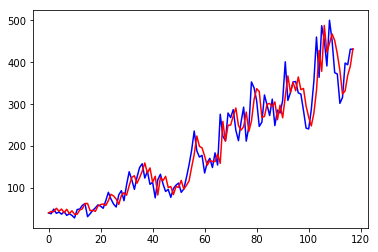

In [16]:
print('Comparing the model (red) to original data (blue)')
pyplot.plot(y, color='blue')
pyplot.plot(yhat, color='red')
pyplot.show()

### 2 Create a AIC grid search and run 'robberies.csv' through it to find the optimum p,d,q order 
### What is the optimum p,d,q order?

In [17]:
# Grid Search – AIC

import warnings
warnings.filterwarnings("ignore") 

seasdiff = y

# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore") 
best_score, best_cfg = float("inf"), None

for p in p_values:
    for d in d_values: 
        for q in q_values:
            order = (p,d,q)
            try:
                model = ARIMA(seasdiff, order) 
                model_fit = model.fit(disp=0)
                AIC = ARIMAResults.aic(model_fit)
                if AIC < best_score:
                    best_score, best_cfg = AIC, order
                #print('ARIMA%s AIC=%.3f' % (order,AIC))
            except:
                continue

print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_score))

# Grid Search – AIC
# Best ARIMA(6, 1, 3) AIC=1182.729

Best ARIMA(6, 1, 3) AIC=1182.729


In [18]:
# Best ARIMA(6, 1, 3) AIC=1182.729
# The optimum p,d,q order is (6, 1, 3)

### Problem 3 
### Compare the results of your orginal (p,d,q) estimate to the results from the grid search (p,d,q).

In [19]:
print('ARIMA(2,1,1)')
model = ARIMA(y, order=(2,1,1)) 
model_fit = model.fit(disp=0)
# summary of fit model 
print(model_fit.summary())
print()
print()
print('ARIMA(6,1,3)')
model_AIC = ARIMA(y, order=(6,1,3)) 
model_fit_AIC = model_AIC.fit(disp=0)
# summary of fit model 
print(model_fit_AIC.summary())

ARIMA(2,1,1)
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  117
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -592.107
Method:                       css-mle   S.D. of innovations             38.118
Date:                Fri, 22 Apr 2022   AIC                           1194.213
Time:                        23:11:18   BIC                           1208.024
Sample:                             1   HQIC                          1199.820
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2980      2.539      1.299      0.197      -1.679       8.275
ar.L1.D.y     -0.8811      0.168     -5.235      0.000      -1.211      -0.551
ar.L2.D.y     -0.3641      0.086     -4

Best AIC (with constant) ARIMA(6,1,3) Model has lower S.D. of innovations and AIC.

ARIMA(2,1,1)


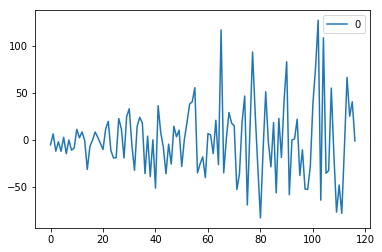

ARIMA(6,1,3)


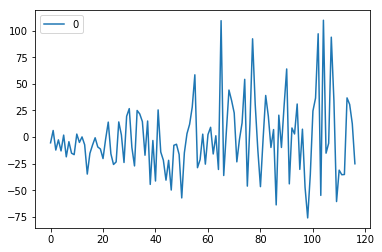

In [20]:
print('ARIMA(2,1,1)')

#line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

print('ARIMA(6,1,3)')

#line plot of residuals
residuals_AIC = DataFrame(model_fit_AIC.resid)
residuals_AIC.plot()
pyplot.show()

They seem like white noise.

ARIMA(2,1,1)


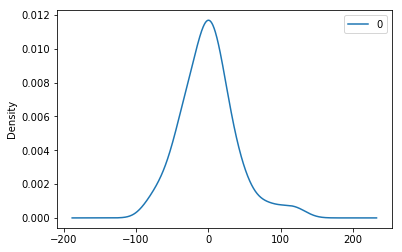

ARIMA(6,1,3)


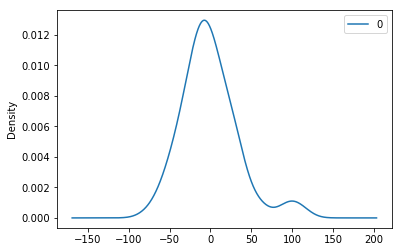

In [21]:
print('ARIMA(2,1,1)')

#density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

print('ARIMA(6,1,3)')
residuals_AIC.plot(kind='kde')
pyplot.show()

The distributions do have a Gaussian look but they are not perfect Gaussian distributions.

### Compare the residuals summaries.

In [22]:
print('ARIMA(2,1,1)')
#summary stats of residuals
print(residuals.describe())

print('ARIMA(6,1,3)')
#summary stats of residuals
print(residuals_AIC.describe())

ARIMA(2,1,1)
                0
count  117.000000
mean     0.002909
std     38.282841
min    -83.077287
25%    -25.757267
50%     -0.239539
75%     18.435384
max    127.310477
ARIMA(6,1,3)
                0
count  117.000000
mean    -1.033466
std     34.379642
min    -76.025204
25%    -21.853583
50%     -5.024431
75%     14.589501
max    109.871794


ARIMA(6,1,3) model has lower standard deviation but the mean value is away from zero.

### Compare the graphs generated by the script made in 1.l above.

In [23]:
model_AIC = ARIMA(y, order=(6,1,3)) 
model_fit_AIC = model_AIC.fit(disp=0)

#diff_hat = diff - resids
resids_AIC = model_fit_AIC.resid
diff_hat_AIC = list()
for t in range(0, len(resids_AIC)):
    value = diff[t] - resids_AIC[t]
    diff_hat_AIC.append(value)
    
#adding back the seasonal differencing
yhat_AIC = list()
for t in range(0, Diff): # backfilling yhat with the first points in y
    yhat_AIC.append(y[t])
for t in range(0,len(diff_hat_AIC)):
    value = diff_hat_AIC[t] + y[t]
    yhat_AIC.append(value)

Comparing the ARIMA(6,1,3) model (red) to original model (blue)


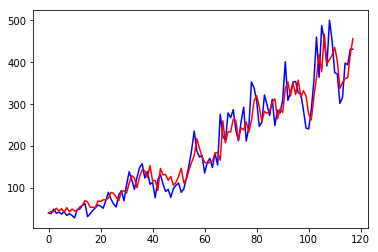

Comparing the ARIMA(2,1,1) model (red) to original data (blue)


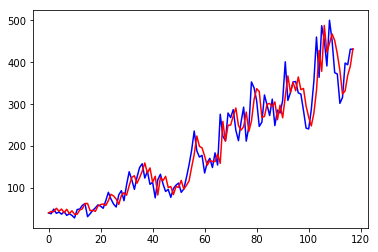

In [24]:
print('Comparing the ARIMA(6,1,3) model (red) to original model (blue)')
pyplot.plot(y, color='blue')
pyplot.plot(yhat_AIC, color='red')
pyplot.show()

print('Comparing the ARIMA(2,1,1) model (red) to original data (blue)')
pyplot.plot(y, color='blue')
pyplot.plot(yhat, color='red')
pyplot.show()

It's hard to say which one has better fit. In my opinion, ARIMA(2,1,1) model has better fit.

### 4 Forecast 'robberies.csv' based on an ARIMA(2,1,1) model:
Split the series into 75% train, 25% test

### a. Perform a dynamic forecast for all points in 'test'
Plot the forecasted data and the prediction intervals on top of the actual data

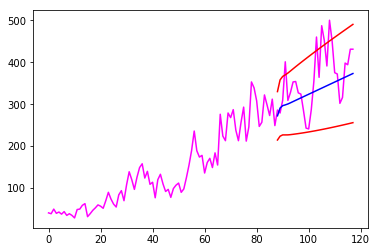


Full prediction interval:


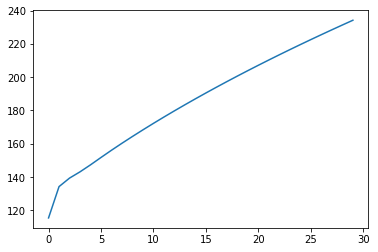

In [25]:
# Dynamic Forecast

series = read_csv('robberies.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

# split into train and test sets
X = series.values
X = X.astype('float64')

size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)] 
history = [x for x in train] 

#model hyperparameters
p=2
d=1
q=1

#forecasting using the same coefficients determined in the train set
model = ARIMA(history, order=(p,d,q)) 
model_fit = model.fit(disp=0)
predictions =model_fit.forecast(steps=len(test))[0]
limits = DataFrame(model_fit.forecast(steps=len(test))[2])
lowerlimit = limits[0]
upperlimit = limits[1]
predictionint = upperlimit - lowerlimit

pyplot.plot(X, color = 'magenta')
pyplot.plot([None for i in train] + [x for x in predictions], color='blue')
pyplot.plot([None for i in train] + [x for x in lowerlimit], color='red')
pyplot.plot([None for i in train] + [x for x in upperlimit], color='red')
pyplot.show()
print()
print('Full prediction interval:')
pyplot.plot(predictionint)
pyplot.show()

### b. Perform a rolling forecast for all points in 'test'
### Plot the forecasted data and the prediction intervals on top of the actual data

predicted=272.287988, expected=286.000000
predicted=298.817208, expected=279.000000
predicted=289.525755, expected=309.000000
predicted=308.059387, expected=401.000000
predicted=364.606450, expected=309.000000
predicted=310.591726, expected=328.000000
predicted=330.552249, expected=353.000000
predicted=344.866377, expected=354.000000
predicted=347.608659, expected=327.000000
predicted=336.462002, expected=324.000000
predicted=337.337397, expected=285.000000
predicted=315.233023, expected=243.000000
predicted=287.444048, expected=241.000000
predicted=279.420132, expected=287.000000
predicted=304.985630, expected=355.000000
predicted=347.327524, expected=460.000000
predicted=419.031823, expected=364.000000
predicted=349.529532, expected=487.000000
predicted=430.026807, expected=452.000000
predicted=427.221179, expected=391.000000
predicted=389.246508, expected=500.000000
predicted=461.709307, expected=451.000000
predicted=457.925330, expected=375.000000
predicted=429.096608, expected=372

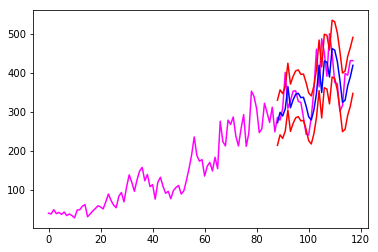


Full prediction interval:


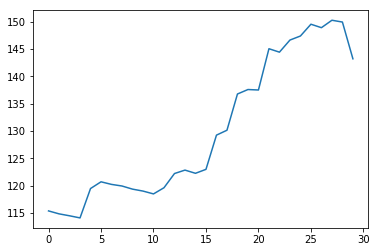

In [26]:
# Rolling Forecast

series = read_csv('robberies.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

# split into train and test sets
X = series.values
X = X.astype('float64')

size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)] 
history = [x for x in train] 

#model hyperparameters
p=2
d=1
q=1

predictions = list()
lowerlimit = list()
upperlimit = list()
predictionint = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(p,d,q)) 
    model_fit = model.fit(disp=0)
    
    yhat = model_fit.forecast()[0]
    lolim = model_fit.forecast()[2][0][0]
    uplim = model_fit.forecast()[2][0][1]
    interval = uplim - lolim
    
    predictions.append(yhat)
    lowerlimit.append(lolim)
    upperlimit.append(uplim)
    predictionint.append(interval)
    
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)


pyplot.plot(history, color = 'magenta')
pyplot.plot([None for i in train] + [x for x in predictions], color='blue')
pyplot.plot([None for i in train] + [x for x in lowerlimit], color='red')
pyplot.plot([None for i in train] + [x for x in upperlimit], color='red')
pyplot.show()
print()
print('Full prediction interval:')
pyplot.plot(predictionint)
pyplot.show()